In [29]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pytesseract
plt.style.use('dark_background')

# Read Input Image

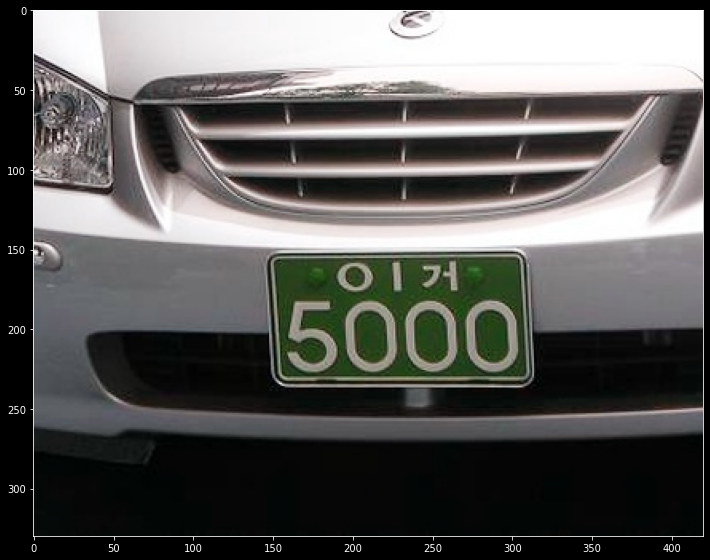

In [51]:
img_ori = cv2.imread('testimg3.jpg')

height, width, channel = img_ori.shape

plt.figure(figsize=(12, 10))
plt.imshow(img_ori, cmap='gray')

# Convert Image to Grayscale

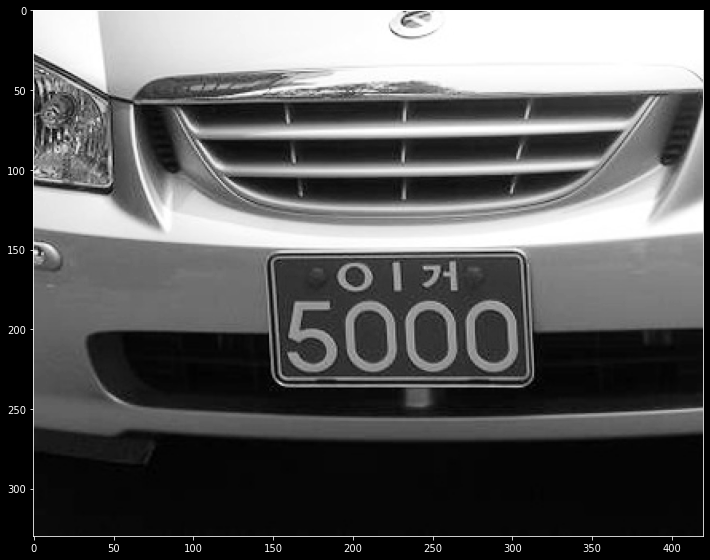

In [52]:
# hsv = cv2.cvtColor(img_ori, cv2.COLOR_BGR2HSV)
# gray = hsv[:,:,2]
gray = cv2.cvtColor(img_ori, cv2.COLOR_BGR2GRAY)

plt.figure(figsize=(12, 10))
plt.imshow(gray, cmap='gray')

# Maximize Contrast (Optional)

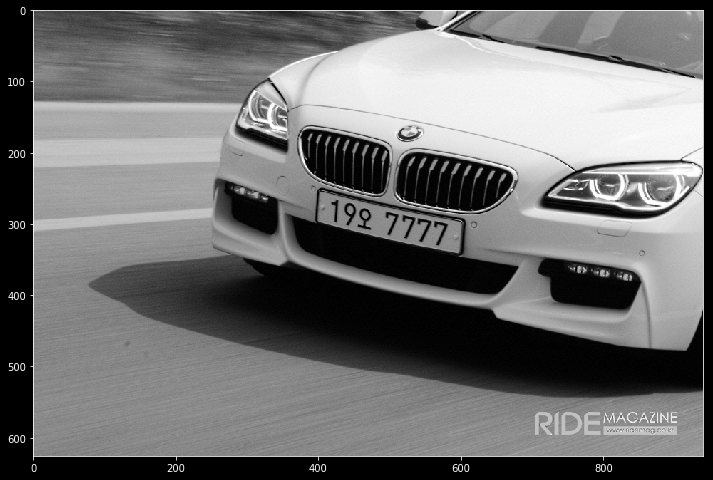

In [15]:
structuringElement = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))

imgTopHat = cv2.morphologyEx(gray, cv2.MORPH_TOPHAT, structuringElement)
imgBlackHat = cv2.morphologyEx(gray, cv2.MORPH_BLACKHAT, structuringElement)

imgGrayscalePlusTopHat = cv2.add(gray, imgTopHat)
gray = cv2.subtract(imgGrayscalePlusTopHat, imgBlackHat)

plt.figure(figsize=(12, 10))
plt.imshow(gray, cmap='gray')

# Adaptive Thresholding

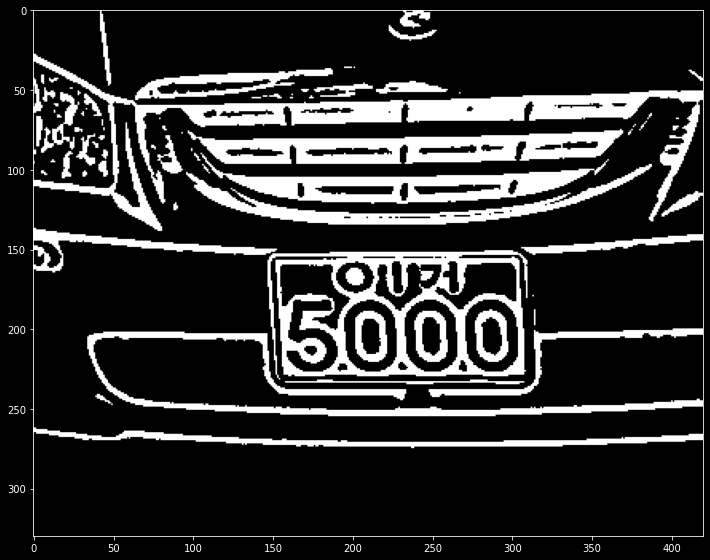

In [53]:
#이미지의 노이즈를 제거하는 단계, 불필요한 부분을 제거
img_blurred = cv2.GaussianBlur(gray, ksize=(5, 5), sigmaX=0)

#이미지의 값을 분명하게 0과 255로 나눔
img_thresh = cv2.adaptiveThreshold(
    img_blurred, 
    maxValue=255.0, 
    adaptiveMethod=cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
    thresholdType=cv2.THRESH_BINARY_INV, 
    blockSize=19, 
    C=9
)

plt.figure(figsize=(12, 10))
plt.imshow(img_thresh, cmap='gray')

# Find Contours

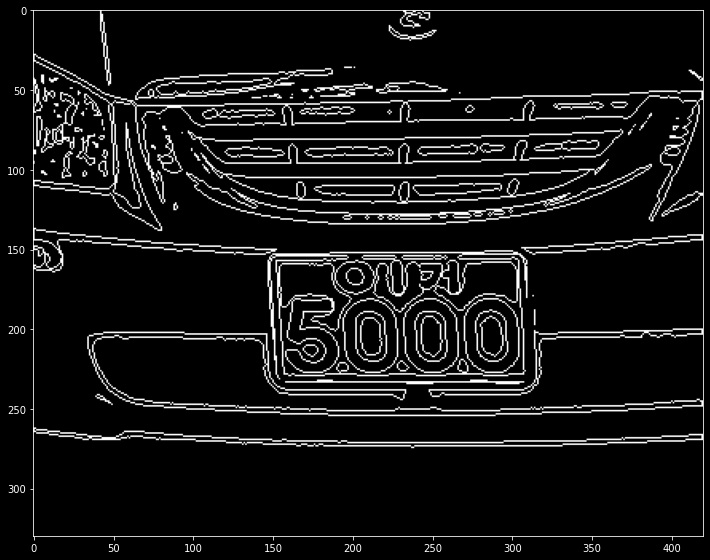

In [55]:
#_, contours, _ = cv2.findContours(
#선따기
contours, _ = cv2.findContours(
    img_thresh, 
    mode=cv2.RETR_LIST, 
    method=cv2.CHAIN_APPROX_SIMPLE
)

temp_result = np.zeros((height, width, channel), dtype=np.uint8)
#그리기 contourIdx를 -1로 주면 모든 윤곽선을 그림
cv2.drawContours(temp_result, contours=contours, contourIdx=-1, color=(255, 255, 255))

plt.figure(figsize=(12, 10))
plt.imshow(temp_result)

# Prepare Data

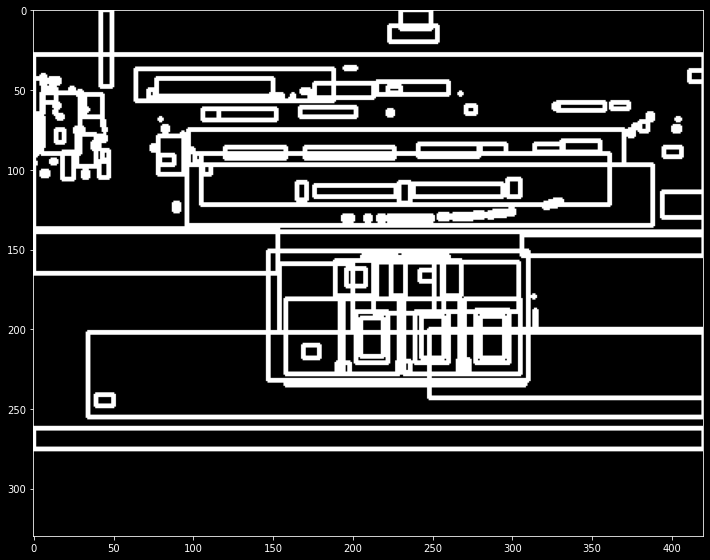

In [56]:
temp_result = np.zeros((height, width, channel), dtype=np.uint8)
#저장할 사각형들의 리스트
contours_dict = []

#윤곽선을 감싸는 사각형을 구한다
for contour in contours:
    x, y, w, h = cv2.boundingRect(contour)
    #사각형을 그림
    cv2.rectangle(temp_result, pt1=(x, y), pt2=(x+w, y+h), color=(255, 255, 255), thickness=2)
    
    #리스트에 각 윤곽선 정보 저장, cx,cy는 중심
    # insert to dict
    contours_dict.append({
        'contour': contour,
        'x': x,
        'y': y,
        'w': w,
        'h': h,
        'cx': x + (w / 2),
        'cy': y + (h / 2)
    })

plt.figure(figsize=(12, 10))
plt.imshow(temp_result, cmap='gray')

# Select Candidates by Char Size

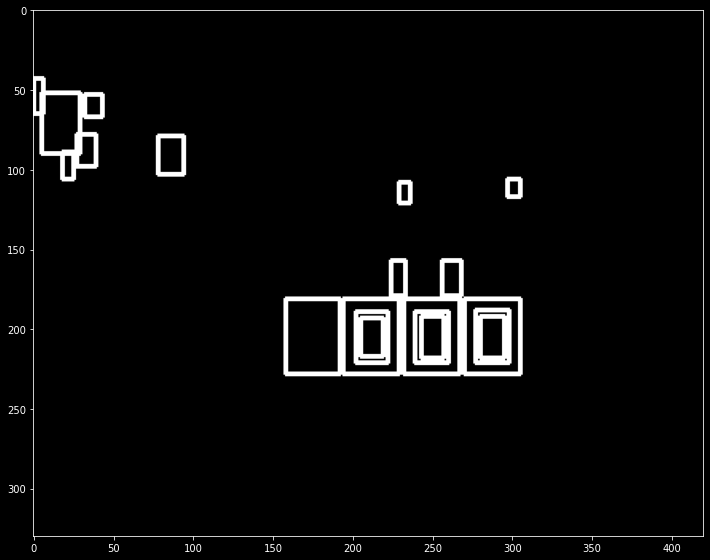

In [57]:
#윤곽선의 사각형(이하 사각형) 중 번호판에 맞는 사각형을 추려냄
#번호판 숫자의 비율이 어느정도 정해져있기 때문에 특정 값을 지정해줌
#최소넓이 80, 최소 너비와 높이 2,8 가로세로 비율은 최소 0.25 최대 1.0
MIN_AREA = 80
MIN_WIDTH, MIN_HEIGHT = 2, 8
MIN_RATIO, MAX_RATIO = 0.25, 1.0

#조건에 부합하는 리스트
possible_contours = []

cnt = 0
#윤곽선
for d in contours_dict:
    area = d['w'] * d['h']
    ratio = d['w'] / d['h']
    
    #조건 비교
    if area > MIN_AREA \
    and d['w'] > MIN_WIDTH and d['h'] > MIN_HEIGHT \
    and MIN_RATIO < ratio < MAX_RATIO:
        #추가적으로 인덱스를 만들어 저장
        d['idx'] = cnt
        cnt += 1
        possible_contours.append(d)
        
# visualize possible contours
temp_result = np.zeros((height, width, channel), dtype=np.uint8)

for d in possible_contours:
#     cv2.drawContours(temp_result, d['contour'], -1, (255, 255, 255))
    cv2.rectangle(temp_result, pt1=(d['x'], d['y']), pt2=(d['x']+d['w'], d['y']+d['h']), color=(255, 255, 255), thickness=2)

plt.figure(figsize=(12, 10))
plt.imshow(temp_result, cmap='gray')

# Select Candidates by Arrangement of Contours

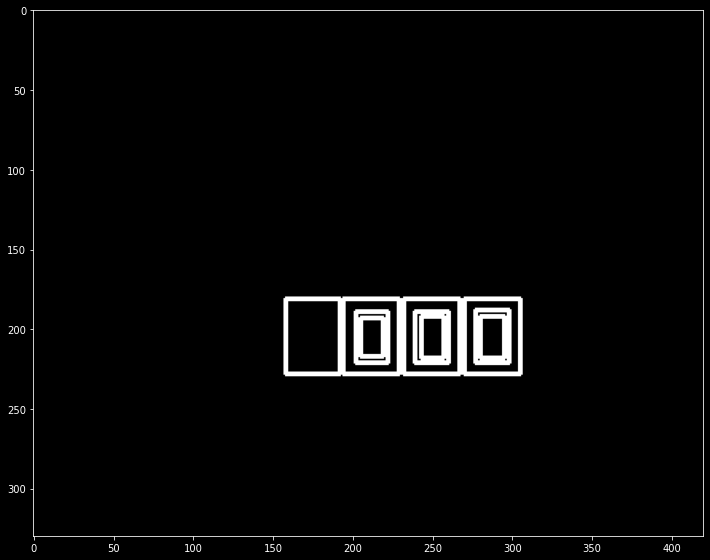

In [58]:
MAX_DIAG_MULTIPLYER = 5 # 5 사각형 중심 사이의 최대 길이 대각선길이의 5배
MAX_ANGLE_DIFF = 12.0 # 12.0 두 사각형 중심의 각도 최댓값
MAX_AREA_DIFF = 0.5 # 0.5 두 사각형의 면적 차이 최댓값
MAX_WIDTH_DIFF = 0.8 #두 사각형의 너비차이 최댓값
MAX_HEIGHT_DIFF = 0.2 #두 사각형의 높이 차이 최댓값
MIN_N_MATCHED = 3 # 3 한 그룹에 속해야 하는 사각형의 수

def find_chars(contour_list):
    #최종번호판의 인덱스
    matched_result_idx = []
    #사각형 두개를 비교
    for d1 in contour_list:

        #비교할 후보군 리스트
        matched_contours_idx = []
        for d2 in contour_list:
            #같은거는 무시
            if d1['idx'] == d2['idx']:
                continue
            #중심점의 너비와 높이차이
            dx = abs(d1['cx'] - d2['cx'])
            dy = abs(d1['cy'] - d2['cy'])

            diagonal_length1 = np.sqrt(d1['w'] ** 2 + d1['h'] ** 2)

            #두 벡터 사이의 거리를 구한다
            distance = np.linalg.norm(np.array([d1['cx'], d1['cy']]) - np.array([d2['cx'], d2['cy']]))

            #각도차이 계산 
            if dx == 0:
                #에러처리 x거리가 0이란것은 수직으로 처리하여 확률을 낮춰버림
                angle_diff = 90
            else:
                #아크탄젠트 값의 라디안을 각도로 수정
                angle_diff = np.degrees(np.arctan(dy / dx))
            #면적비율
            area_diff = abs(d1['w'] * d1['h'] - d2['w'] * d2['h']) / (d1['w'] * d1['h'])
            #너비비율
            width_diff = abs(d1['w'] - d2['w']) / d1['w']
            #높이 비율
            height_diff = abs(d1['h'] - d2['h']) / d1['h']
            #비율 비교
            if distance < diagonal_length1 * MAX_DIAG_MULTIPLYER \
            and angle_diff < MAX_ANGLE_DIFF and area_diff < MAX_AREA_DIFF\
            and width_diff < MAX_WIDTH_DIFF and height_diff < MAX_HEIGHT_DIFF:
                #조건에 부합하는 d2를 넣음
                matched_contours_idx.append(d2['idx'])

        # append this contour
        #마지막에 d1넣어줌
        matched_contours_idx.append(d1['idx'])

        #후보군의 개수가 3보다 작으면 번호판이 아님.
        if len(matched_contours_idx) < MIN_N_MATCHED:
            continue

        #조건에 부합하면 최종 후보군에 넣어줌
        matched_result_idx.append(matched_contours_idx)

        #최종후보가 아닌 사각형 다시 비교
        unmatched_contour_idx = []
        for d4 in contour_list:
            if d4['idx'] not in matched_contours_idx:
                unmatched_contour_idx.append(d4['idx'])
        #인덱스 추출
        unmatched_contour = np.take(possible_contours, unmatched_contour_idx)
        
        # recursive 재귀로 돌려줌
        recursive_contour_list = find_chars(unmatched_contour)
        #최종결과물에 다시 넣어줌
        for idx in recursive_contour_list:
            matched_result_idx.append(idx)

        break
    #결과물을 반환
    return matched_result_idx
    
result_idx = find_chars(possible_contours)

matched_result = []
for idx_list in result_idx:
    matched_result.append(np.take(possible_contours, idx_list))

# visualize possible contours
temp_result = np.zeros((height, width, channel), dtype=np.uint8)

for r in matched_result:
    for d in r:
#         cv2.drawContours(temp_result, d['contour'], -1, (255, 255, 255))
        cv2.rectangle(temp_result, pt1=(d['x'], d['y']), pt2=(d['x']+d['w'], d['y']+d['h']), color=(255, 255, 255), thickness=2)

plt.figure(figsize=(12, 10))
plt.imshow(temp_result, cmap='gray')

# Rotate Plate Images

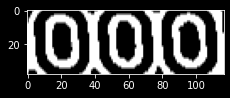

In [59]:
#Affine tranceform을 사용해서 기울어진 이미지를 수정
PLATE_WIDTH_PADDING = 1.3 # 1.3
PLATE_HEIGHT_PADDING = 1.5 # 1.5
MIN_PLATE_RATIO = 3
MAX_PLATE_RATIO = 10

plate_imgs = []
plate_infos = []

for i, matched_chars in enumerate(matched_result):
    #리스트에 대해 순차적으로 x를 기준으로 정렬해줌
    sorted_chars = sorted(matched_chars, key=lambda x: x['cx'])

    #번호판의 중심좌표를 굴함
    plate_cx = (sorted_chars[0]['cx'] + sorted_chars[-1]['cx']) / 2
    plate_cy = (sorted_chars[0]['cy'] + sorted_chars[-1]['cy']) / 2
    #너비도
    plate_width = (sorted_chars[-1]['x'] + sorted_chars[-1]['w'] - sorted_chars[0]['x']) * PLATE_WIDTH_PADDING
    
    sum_height = 0
    for d in sorted_chars:
        sum_height += d['h']

    #높이도 구함
    plate_height = int(sum_height / len(sorted_chars) * PLATE_HEIGHT_PADDING)
    
    #각도를 알아야 회전이 가능. 직각삼각형을 만들어서 아크사인을 사용함.
    #삼각형의 높이
    triangle_height = sorted_chars[-1]['cy'] - sorted_chars[0]['cy']
    #빛변의 길이
    triangle_hypotenus = np.linalg.norm(
        np.array([sorted_chars[0]['cx'], sorted_chars[0]['cy']]) - 
        np.array([sorted_chars[-1]['cx'], sorted_chars[-1]['cy']])
    )
    #아크사인을 사용하여 라디안을 구하여 각도로 바꿈
    angle = np.degrees(np.arcsin(triangle_height / triangle_hypotenus))
    
    #로테이션 메트릭스를 구한다.
    rotation_matrix = cv2.getRotationMatrix2D(center=(plate_cx, plate_cy), angle=angle, scale=1.0)
    
    #이미지를 정렬할 수 있다.
    img_rotated = cv2.warpAffine(img_thresh, M=rotation_matrix, dsize=(width, height))

    #이미지를 자른다. 번호판 부분만 네모모양으로.
    img_cropped = cv2.getRectSubPix(
        img_rotated, 
        patchSize=(int(plate_width), int(plate_height)), 
        center=(int(plate_cx), int(plate_cy))
    )
    
    if img_cropped.shape[1] / img_cropped.shape[0] < MIN_PLATE_RATIO or img_cropped.shape[1] / img_cropped.shape[0] < MIN_PLATE_RATIO > MAX_PLATE_RATIO:
        continue
    
    plate_imgs.append(img_cropped)
    plate_infos.append({
        'x': int(plate_cx - plate_width / 2),
        'y': int(plate_cy - plate_height / 2),
        'w': int(plate_width),
        'h': int(plate_height)
    })
    
    plt.subplot(len(matched_result), 1, i+1)
    plt.imshow(img_cropped, cmap='gray')

# Another Thresholding to Find Chars

01010


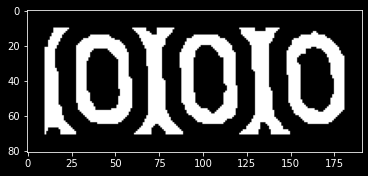

In [60]:
longest_idx, longest_text = -1, 0
plate_chars = []

#한번 더 이미지를 0과 255로 구분함
for i, plate_img in enumerate(plate_imgs):
    plate_img = cv2.resize(plate_img, dsize=(0, 0), fx=1.6, fy=1.6)
    _, plate_img = cv2.threshold(plate_img, thresh=0.0, maxval=255.0, type=cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    
    # find contours again (same as above)
    #한번 더 사각형을 구함
    #_, contours, _ = cv2.findContours(
    contours, _ = cv2.findContours(
        plate_img, mode=cv2.RETR_LIST, method=cv2.CHAIN_APPROX_SIMPLE)
    
    plate_min_x, plate_min_y = plate_img.shape[1], plate_img.shape[0]
    plate_max_x, plate_max_y = 0, 0

    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        
        area = w * h
        ratio = w / h

        if area > MIN_AREA \
        and w > MIN_WIDTH and h > MIN_HEIGHT \
        and MIN_RATIO < ratio < MAX_RATIO:
        #번호판의 최대 최소 x,y를 구함
            if x < plate_min_x:
                plate_min_x = x
            if y < plate_min_y:
                plate_min_y = y
            if x + w > plate_max_x:
                plate_max_x = x + w
            if y + h > plate_max_y:
                plate_max_y = y + h
    #이미지를 번호만 있는 부분으로 잘라낼 수 있음            
    img_result = plate_img[plate_min_y:plate_max_y, plate_min_x:plate_max_x]
    
    #한번더 이미지 처리
    img_result = cv2.GaussianBlur(img_result, ksize=(3, 3), sigmaX=0)
    _, img_result = cv2.threshold(img_result, thresh=0.0, maxval=255.0, type=cv2.THRESH_BINARY | cv2.THRESH_OTSU)

    #이미지에 패딩을 준다.(여백주기 검정색으로, 더 잘 인식하라고. 글씨가 하양이니까 )
    img_result = cv2.copyMakeBorder(img_result, top=10, bottom=10, left=10, right=10, borderType=cv2.BORDER_CONSTANT, value=(0,0,0))

    pytesseract.pytesseract.tesseract_cmd = "C:\\Program Files\\Tesseract-OCR\\tesseract"

    #pytesseract의 함수를 이용해서 글씨를 읽어낸다
    chars = pytesseract.image_to_string(img_result, lang='kor', config='--psm 7 --oem 0')
    #psm 7은 이미지가 일렬로 있다고 알려주는 것이고, oem 0 은 가장 오래된 엔진을 사용하는 것이다.
    #0번을 쓰는 이유는 별다른 기능(문맥파악등)없이 문자를 그대로 인식하기 위함

    result_chars = ''
    has_digit = False
    for c in chars:
        #읽어낸 결과에 숫자나 한글이 포함되어 있는지 확인
        if ord('가') <= ord(c) <= ord('힣') or c.isdigit():
            if c.isdigit():
                #숫자가 하나라도 있는지 표시
                has_digit = True
            result_chars += c
    
    print(result_chars)
    plate_chars.append(result_chars)

    #가장 긴 것을 번호판으로 지정
    if has_digit and len(result_chars) > longest_text:
        longest_idx = i

    plt.subplot(len(plate_imgs), 1, i+1)
    plt.imshow(img_result, cmap='gray')

# Result

01010


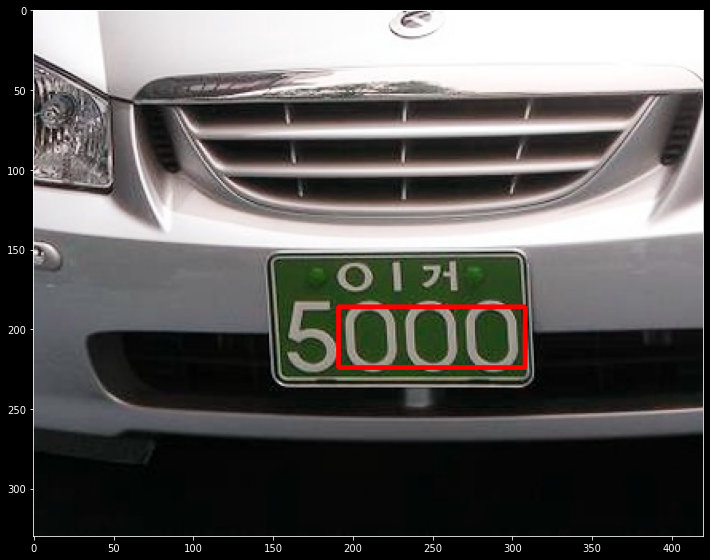

In [61]:
info = plate_infos[longest_idx]
chars = plate_chars[longest_idx]

print(chars)

img_out = img_ori.copy()

cv2.rectangle(img_out, pt1=(info['x'], info['y']), pt2=(info['x']+info['w'], info['y']+info['h']), color=(255,0,0), thickness=2)

cv2.imwrite(chars + '.jpg', img_out)

plt.figure(figsize=(12, 10))
plt.imshow(img_out)